In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Edit the lag function
# Add a regression model
# Look at other FE based on literature


In [2]:
from sklearn.linear_model import LinearRegression, Lasso # baseline
from lightgbm import LGBMRegressor # goodest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,r2_score

sns.set(font_scale=1.2)
random_state = 42

## 0. Define Helper Functions

In [431]:
def get_regression_df(ticker_name, comments, fin_data):
    
    ##### GET COMMENT VOLUME ######
    # Drop NA from comments
    comments = comments[~comments['created_utc'].isna()]
    
    # Grab only the ticker assignment and the date
    comment_vol_df = comments[['created_utc', 'ticker']]
    comment_vol_df['created_utc'] = pd.to_numeric(comment_vol_df['created_utc'], errors = 'coerce')

    # Remove NAs created by the coerce
    comment_vol_df = comment_vol_df[~comment_vol_df['created_utc'].isna()]
    comment_vol_df['created_utc'] = comment_vol_df['created_utc'].astype(int)
    comment_vol_df['created_utc'] = pd.to_datetime(comment_vol_df['created_utc'],unit= 's')
    comment_vol_df['date'] = comment_vol_df['created_utc'].dt.date
    comment_vol_df['date'] = pd.DatetimeIndex(comment_vol_df['date'])
    
    # Create a binary column for stock
    for stock in stocks:
        comment_vol_df[stock] = np.where(comment_vol_df['ticker'] == stock, 1, 0)
    
    aggregations = {}
    for stock in stocks:
        aggregations[stock] = np.sum
    
    comment_vol_grouped = comment_vol_df.groupby(['date']).agg(aggregations).reset_index().sort_values(['date'])
    # Only one line of weird values, drop
    comment_vol_grouped[comment_vol_grouped['date'] < pd.Timestamp('2021-01-01')]
    comment_vol_grouped=comment_vol_grouped[~(comment_vol_grouped['date'] < pd.Timestamp('2021-01-01'))]
    
    # Filter down to only the stock's data
    comment_vol_grouped = comment_vol_grouped[['date', ticker_name]]
    
    ##### BUILD EMPTY DATE DF ######
    # Build an empty df with date only
    start_date = '2021-01-01'
    end_date = '2022-01-01'

    # Generate a list of month-end closes
    start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_generated = pd.date_range(start, end, freq='D')

    # Format date columns 
    df = pd.DataFrame(date_generated)
    df.columns = ['date'] # rename column
    df = df.merge(comment_vol_grouped, how = 'left', on = 'date')
    df = df.fillna(0)
    
    ##### GET MEME PERIOD ######
    df['7_day_avg'] = df[ticker_name].rolling(7).mean() 
    df['30_day_avg'] = df[ticker_name].rolling(30).mean() 
    df['is_meme'] = np.where((df[ticker_name] > df['30_day_avg']*2)
                                 & (df[ticker_name]>df[ticker_name].quantile(0.90))
                                 , 1 ,0 )
    
    # Formatting
    df = df.drop(['7_day_avg', '30_day_avg'], axis = 1)
    df.rename(columns={ticker_name: 'comment_count'}, inplace = True)
    
    ##### JOIN POST DATA ######
    # rolling comment count or percentage change is not useful
    # for i in range(1,8):
    #     if i > 1:
    #         roll = df['comment_count'].rolling(i).sum()
    #         df= df.join(roll, rsuffix = '_rolling_'+str(i)+'D')
    #         mean = df['comment_count'].rolling(i).mean()
    #         df = df.join(mean, rsuffix = '_mean_rolling_'+str(i)+'D')
    #     pct_change = df['comment_count'].pct_change(periods=i)*100
    #     df = df.join(pct_change, rsuffix= '_'+str(i)+'days_pct_change')
    # df.replace([np.inf, -np.inf],100, inplace=True)
    
    #EWM IS NOT USEFUL
    df['comment_count_ewm'] = df['comment_count'].ewm(span=3).sum()
    df['comment_count_mean_ewm'] = df['comment_count'].ewm(span=3).mean()
    df['is_meme_ewm'] = df['is_meme'].ewm(span=3).mean()
    
    
    ##### JOIN FINANCIAL DATA ######
    fin_data['date'] = pd.DatetimeIndex(fin_data['date'])
    fin_data = fin_data.drop(['Unnamed: 0', 'TICKER'], axis = 1)
    df = df.merge(fin_data, how = 'left', on = 'date')
    df['day_of_week'] = df['date'].dt.dayofweek # create day-of-week 0 = monday
    
    df.rename(columns={'Close_x': 'Close',
                       'Open_x': 'Open',
                       'High_x': 'High',
                       'Low_x': 'Low',
                      'Volume_x': 'Volume'}, inplace = True)
    
    ##### ADDITIONAL FEATUERS ######
    df['SD_log'] = np.log(df['SD'])
    df['Volume_log'] = np.log(df['Volume'])
    
    return df

In [348]:
def lag_variables(data, vars_to_lag, shift_by):
    df = data.copy()
    for variable in vars_to_lag:
        df['{}(t-{})'.format(variable,shift_by)] = df[variable].shift(periods = shift_by)
        # Drop the original column once done
        df = df.drop(variable, axis = 1)
    return df

In [349]:
def fit_and_score_reg(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(r2_score(y_train, pred_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(r2_score(y_test, pred_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model

def fit_and_score_clf(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    pred_proba_train = model.predict_proba(X_train)[:,1]
    train_acc = accuracy_score(y_train, pred_train)
    train_auc = roc_auc_score(y_train, pred_proba_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['accuracy', 'roc_auc'], verbose=0, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    pred_proba_test = model.predict_proba(X_test)[:,1]
    test_acc = accuracy_score(y_test, pred_test)
    test_auc = roc_auc_score(y_test, pred_proba_test)
    
    print('Train Accuracy', round(train_acc,4))
    print('Train AUC:', round(train_auc,4))
    print('')
    print('CV Accuracy', round(np.mean(cv_score['test_accuracy']),4))
    print('CV AUC:', round(np.mean(cv_score['test_roc_auc']),4))
    print('')
    print('Test Accuracy', round(test_acc,4))
    print('Test AUC:', round(test_auc,4))
    
    return model

def random_search_pipe(model, grid, X_train, y_train, reg_or_clf):
    
    if reg_or_clf == 'reg':
        scoring = 'r2'
    elif reg_or_clf == 'clf':
        scoring = 'accuracy'
        
    search = RandomizedSearchCV(model, grid, cv=5, scoring=scoring, n_iter = 100)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

In [350]:
def lag_pred_df(dep_var, other_var, fin_vars, sentiment_vars, shift):
    pred_df = df[dep_var+other_var+fin_vars+sentiment_vars]

    # Remove saturday and sunday --> assume that comment changes over the weekend will affect Monday
    # Lag sentiment first, in place
    pred_lag = lag_variables(data = pred_df, 
                             vars_to_lag = sentiment_vars, 
                             shift_by = shift)

    # Drop weekends, dependent variable is only present for trading days 
    print('Length of dataframe before dropping weekends: {}'.format(len(pred_lag)))
    pred_lag = pred_lag.dropna(subset=dep_var).reset_index(drop=True)
    print('Length of dataframe after dropping weekends: {}'.format(len(pred_lag)))

    # Lag finance variables in place
    pred_lag = lag_variables(data = pred_lag, 
                             vars_to_lag = fin_vars, 
                             shift_by = shift)

    # Lag dependent variable
    dep_keep = pred_lag[dep_var]
    pred_lag = lag_variables(data = pred_lag, 
                             vars_to_lag = dep_var, 
                             shift_by = shift)
    pred_lag = pd.concat([dep_keep, pred_lag], axis = 1)
    
    return pred_lag

## 1. Prepare Prediction Data

In [5]:
tagged = pd.read_csv('tagged_comments.csv')
tagged.head()

,Unnamed: 0,id,sentiment,search_term,tagger,author,body,created_utc,link_id,permalink,score,subreddit,post_name,filename
0,0,glngetr,0,ladvc3,SUPRATIK,nevabraun,Thanks but you’ve lost me at \n\n„If look at A...,1612214426,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,21,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv
1,1,glndurd,1,ladvc3,SUPRATIK,Awake_4E,Awesome 😎! Why the moon 🤔 Let’s shoot AMC out ...,1612213448,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,25,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv
2,2,glndfos,1,ladvc3,SUPRATIK,Cloud9forreal,If you look at AMCs business page you’ll find ...,1612213289,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,58,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv
3,3,glnd58d,1,ladvc3,SUPRATIK,MacCoy69,"I bought 20 today, i am also a retarded dumb m...",1612213186,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,13,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv
4,4,glnd2xt,0,ladvc3,SUPRATIK,Menuler,"Ahh, my fellow Retard. I see the more and more...",1612213163,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,11,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv


In [8]:
len(tagged)

5489

In [432]:
stocks = ['amc', 'bb', 'clov', 'wish', 'pltr', 'tsla', 'amzn', 'nok', 'meta', 'fb']

#DV: DIR (classf), SD (reg), Close (reg) 
# Set all parameters here
comments = pd.read_csv('comments_preprocessed_assigned.csv')
fin_data = pd.read_csv('AMC_2021.csv')

# Call function to get regression df
df = get_regression_df(ticker_name = 'amc', #
                       comments = comments, 
                       fin_data = fin_data)
df.head()

,date,comment_count,is_meme,comment_count_ewm,comment_count_mean_ewm,is_meme_ewm,Open,High,Low,Close,...,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log,Volume_log
0,2021-01-01,42.0,0,42.000,42.000000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
1,2021-01-02,8.0,0,29.000,19.333333,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN
2,2021-01-03,4.0,0,18.500,10.571429,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN
3,2021-01-04,0.0,0,9.250,4.933333,0.0,2.20,2.20,2.00,2.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.788105,0,-0.238123,17.212492
4,2021-01-05,0.0,0,4.625,2.387097,0.0,1.99,2.03,1.91,1.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.815720,1,-0.203684,17.152998


In [433]:
df.columns

Index(['date', 'comment_count', 'is_meme', 'comment_count_ewm',
       'comment_count_mean_ewm', 'is_meme_ewm', 'Open', 'High', 'Low', 'Close',
       'Volume', 'Daily%Change', '2D%Change', '3D%Change', '4D%Change',
       '5D%Change', '6D%Change', '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir',
       '5Dir', '6Dir', '7Dir', 'SD', 'day_of_week', 'SD_log', 'Volume_log'],
      dtype='object')

In [234]:
# # Check meme period graph
# ticker = 'amc'

# ax = sns.lineplot(x = 'date', y = 'comment_count', data = df, legend='auto')
# ax2 = ax.twinx()
# sns.lineplot(x = 'date', y = 'is_meme', data = df, legend='auto', color = 'red', linestyle="dashed", linewidth = 0.8)
# ax.figure.legend()
# plt.ylim(0,2)
# plt.show()

### 1.1 Check Distributions of Y variables

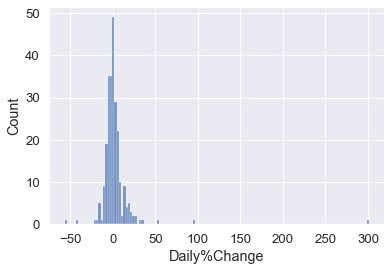

In [237]:
# Check distribution of y variable
sns.histplot(df['Daily%Change'])
plt.show()

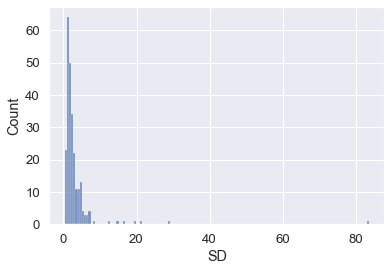

In [236]:
# Check distribution of y variable
# Need to log transform SD
sns.histplot(df['SD'])
plt.show()

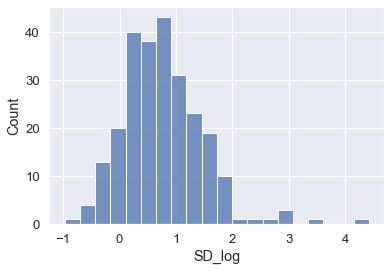

In [235]:
sns.histplot(df['SD_log'])
plt.show()

0.0    128
1.0    122
Name: Dir, dtype: int64


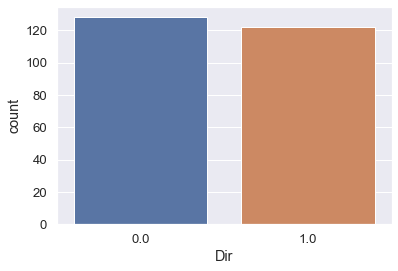

In [238]:
sns.countplot(df['Dir'])
print(df['Dir'].value_counts())
plt.show()

## 2. Continuous Prediction

- DV: Close
- DV: Daily % Change
- DV: SD

### 2.1 Daily % Change

In [481]:
## SET PARAMS ##
dep_var = ['Daily%Change']
other_var = ['day_of_week']
fin_vars = ['Close', 'SD','Volume_log', 'Dir']
sentiment_vars = ['comment_count_ewm', 'comment_count_mean_ewm', 'is_meme_ewm',
                  'comment_count', 'is_meme']
shift = 1

pred_lag = lag_pred_df(dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag.head()

Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,comment_count_ewm(t-1),comment_count_mean_ewm(t-1),is_meme_ewm(t-1),comment_count(t-1),is_meme(t-1),Close(t-1),SD(t-1),Volume_log(t-1),Dir(t-1),Daily%Change(t-1)
0,-5.188675,0,18.50000,10.571429,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
1,-1.492536,1,9.25000,4.933333,0.0,0.0,0.0,2.01,0.788105,17.212492,0.0,-5.188675
2,1.515150,2,4.62500,2.387097,0.0,0.0,0.0,1.98,0.815720,17.152998,0.0,-1.492536
3,1.990048,3,2.31250,1.174603,0.0,0.0,0.0,2.01,2.505572,18.025611,1.0,1.515150
4,4.390251,4,1.15625,0.582677,0.0,0.0,0.0,2.05,1.405905,17.079379,1.0,1.990048


In [482]:
X = pred_lag.drop(dep_var, axis = 1)
y = pred_lag[dep_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = random_state)

print('X_train shape: {}'.format(np.shape(X_train)))
print('X_test shape: {}'.format(np.shape(X_test)))
print('y_train shape: {}'.format(np.shape(y_train)))
print('y_test shape: {}'.format(np.shape(y_test)))

# Pipeline to encode and scale
cat_col = ['day_of_week', 'Dir(t-1)']
num_col = [i for i in X.columns if i not in cat_col]
print('Categorical columns: {}'.format(cat_col))
print('Numerical columns: {}'.format(num_col))

# Define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_col),
    ]
    , remainder='passthrough'
)

preprocessor

X_train shape: (200, 11)
X_test shape: (50, 11)
y_train shape: (200, 1)
y_test shape: (50, 1)
Categorical columns: ['day_of_week', 'Dir(t-1)']
Numerical columns: ['comment_count_ewm(t-1)', 'comment_count_mean_ewm(t-1)', 'is_meme_ewm(t-1)', 'comment_count(t-1)', 'is_meme(t-1)', 'Close(t-1)', 'SD(t-1)', 'Volume_log(t-1)', 'Daily%Change(t-1)']


ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['comment_count_ewm(t-1)',
                                  'comment_count_mean_ewm(t-1)',
                                  'is_meme_ewm(t-1)', 'comment_count(t-1)',
                                  'is_meme(t-1)', 'Close(t-1)', 'SD(t-1)',
                                  'Volume_log(t-1)', 'Daily%Change(t-1)']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['day_of_week', 'Dir(t-1)'])])

In [222]:
# LGBM Regression
lgbm = Pipeline([('preprocess', preprocessor),
                ('regressor', LGBMRegressor(random_state = random_state))
               ])

model = fit_and_score_reg(model = lgbm, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

Train R-sq 0.5329
Train MSE: 65.1709

CV R-sq -0.244
CV MSE: 160.7014

Test R-sq -0.0687
Test MSE: 2015.2872


In [224]:
# # Best params:
# # {'regressor__subsample': 0.9222222222222223, 'regressor__num_leaves': 150, 'regressor__n_estimators': 150, 'regressor__max_depth': 16, 'regressor__max_bin': 2, 'regressor__colsample_bytree': 0.8, 'regressor__boosting_type': 'goss', 'preprocess__num': StandardScaler()}
# # Best score:
# # -0.06448025536914334

# random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), None],
#                 'regressor__boosting_type': ['gbdt','dart','goss'],
#                 'regressor__n_estimators': range(50, 500, 50),
#                 'regressor__max_bin':range(2, 20, 2),
#                 'regressor__num_leaves':range(10, 200, 10),
#                 'regressor__max_depth': range(2, 30, 2),
#                 'regressor__colsample_bytree' : np.linspace(0.2, 1, 5),
#                 'regressor__subsample' : np.linspace(0.3, 1, 10)}

# rsearch_lgb = random_search_pipe(model = lgbm, 
#                                  grid = random_grid, 
#                                  X_train = X_train, 
#                                  y_train = y_train, 
#                                  reg_or_clf = 'reg')

In [225]:
# LGBM with best params
lgbm = Pipeline([('preprocess', preprocessor),
                ('regressor', LGBMRegressor(random_state = random_state,
                                           subsample = 0.3,
                                           num_leaves = 180,
                                           n_estimators = 50,
                                           max_depth = 4,
                                           max_bin = 2, 
                                           colsample_bytree = 0.8,
                                           boosting_type = 'goss'))
               ])

model = fit_and_score_reg(model = lgbm, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

Train R-sq 0.0466
Train MSE: 133.0114

CV R-sq -0.0578
CV MSE: 144.2976

Test R-sq -0.0183
Test MSE: 1920.3035


### 2.2 SD

In [323]:
## SET PARAMS ##
dep_var = ['SD_log']
other_var = ['day_of_week']
fin_vars = ['Close', 'Volume','Dir', 'Daily%Change', 'SD'] # adding other variables is not helpful and reduces R2
sentiment_vars = ['comment_count', 'is_meme']
shift = 1

pred_lag = lag_pred_df(dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

X = pred_lag.drop(dep_var, axis = 1)
y = pred_lag[dep_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = random_state)

print('X_train shape: {}'.format(np.shape(X_train)))
print('X_test shape: {}'.format(np.shape(X_test)))
print('y_train shape: {}'.format(np.shape(y_train)))
print('y_test shape: {}'.format(np.shape(y_test)))

# Pipeline to encode and scale
cat_col = ['day_of_week', 'Dir(t-1)']
num_col = [i for i in X.columns if i not in cat_col]
print('Categorical columns: {}'.format(cat_col))
print('Numerical columns: {}'.format(num_col))

# Define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_col),
    ]
    , remainder='passthrough'
)

preprocessor

Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250
X_train shape: (200, 9)
X_test shape: (50, 9)
y_train shape: (200, 1)
y_test shape: (50, 1)
Categorical columns: ['day_of_week', 'Dir(t-1)']
Numerical columns: ['comment_count(t-1)', 'is_meme(t-1)', 'Close(t-1)', 'Volume(t-1)', 'Daily%Change(t-1)', 'SD(t-1)', 'SD_log(t-1)']


ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['comment_count(t-1)', 'is_meme(t-1)',
                                  'Close(t-1)', 'Volume(t-1)',
                                  'Daily%Change(t-1)', 'SD(t-1)',
                                  'SD_log(t-1)']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['day_of_week', 'Dir(t-1)'])])

In [324]:
# LGBM Regression
lgbm = Pipeline([('preprocess', preprocessor),
                ('regressor', LGBMRegressor(random_state = random_state))
               ])

model = fit_and_score_reg(model = lgbm, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

Train R-sq 0.8064
Train MSE: 0.0884

CV R-sq 0.1906
CV MSE: 0.3473

Test R-sq 0.2323
Test MSE: 0.5206


In [325]:
# # Best params:
# # {'regressor__subsample': 0.7666666666666666, 'regressor__num_leaves': 10, 'regressor__n_estimators': 300, 'regressor__max_depth': 16, 'regressor__max_bin': 14, 'regressor__colsample_bytree': 0.4, 'regressor__boosting_type': 'dart', 'preprocess__num': StandardScaler()}
# # Best score:
# # 0.24151223291010004

# random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), None],
#                 'regressor__boosting_type': ['gbdt','dart','goss'],
#                 'regressor__n_estimators': range(50, 500, 50),
#                 'regressor__max_bin':range(2, 20, 2),
#                 'regressor__num_leaves':range(10, 200, 10),
#                 'regressor__max_depth': range(2, 30, 2),
#                 'regressor__colsample_bytree' : np.linspace(0.2, 1, 5),
#                 'regressor__subsample' : np.linspace(0.3, 1, 10)}

# rsearch_lgb = random_search_pipe(model = lgbm, 
#                                  grid = random_grid, 
#                                  X_train = X_train, 
#                                  y_train = y_train, 
#                                  reg_or_clf = 'reg')

In [326]:
# LGBM with best params

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_col),
    ]
    , remainder='passthrough'
)

lgbm = Pipeline([('preprocess', preprocessor),
                ('regressor', LGBMRegressor(random_state = random_state,
                                           subsample = 0.7667,
                                           num_leaves = 10,
                                           n_estimators = 300,
                                           max_depth = 16,
                                           max_bin = 14, 
                                           colsample_bytree = 0.4,
                                           boosting_type = 'dart'))
               ])

model = fit_and_score_reg(model = lgbm, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

Train R-sq 0.622
Train MSE: 0.1726

CV R-sq 0.2415
CV MSE: 0.3277

Test R-sq 0.3649
Test MSE: 0.4307


## 3. Classification

DV: DIR

In [476]:
## SET PARAMS ##
dep_var = ['Dir']
other_var = ['day_of_week']
fin_vars = ['Close', 'SD', 'Volume', 'Daily%Change']
sentiment_vars = ['comment_count_ewm', 'comment_count_mean_ewm', 'is_meme_ewm',
                  'comment_count', 'is_meme']

shift = 1

pred_lag = lag_pred_df(dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag.head()

Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Dir,day_of_week,comment_count_ewm(t-1),comment_count_mean_ewm(t-1),is_meme_ewm(t-1),comment_count(t-1),is_meme(t-1),Close(t-1),SD(t-1),Volume(t-1),Daily%Change(t-1),Dir(t-1)
0,0.0,0,18.50000,10.571429,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0.0,1,9.25000,4.933333,0.0,0.0,0.0,2.01,0.788105,29873800.0,-5.188675,0.0
2,1.0,2,4.62500,2.387097,0.0,0.0,0.0,1.98,0.815720,28148300.0,-1.492536,0.0
3,1.0,3,2.31250,1.174603,0.0,0.0,0.0,2.01,2.505572,67363300.0,1.515150,1.0
4,1.0,4,1.15625,0.582677,0.0,0.0,0.0,2.05,1.405905,26150500.0,1.990048,1.0


In [477]:
X = pred_lag.drop(dep_var, axis = 1)
y = pred_lag[dep_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = random_state)

print('X_train shape: {}'.format(np.shape(X_train)))
print('X_test shape: {}'.format(np.shape(X_test)))
print('y_train shape: {}'.format(np.shape(y_train)))
print('y_test shape: {}'.format(np.shape(y_test)))

# Pipeline to encode and scale
cat_col = ['day_of_week', 'Dir(t-1)']
num_col = [i for i in X.columns if i not in cat_col]
print('Categorical columns: {}'.format(cat_col))
print('Numerical columns: {}'.format(num_col))

# Define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_col),
    ]
    , remainder='passthrough'
)

preprocessor

X_train shape: (200, 11)
X_test shape: (50, 11)
y_train shape: (200, 1)
y_test shape: (50, 1)
Categorical columns: ['day_of_week', 'Dir(t-1)']
Numerical columns: ['comment_count_ewm(t-1)', 'comment_count_mean_ewm(t-1)', 'is_meme_ewm(t-1)', 'comment_count(t-1)', 'is_meme(t-1)', 'Close(t-1)', 'SD(t-1)', 'Volume(t-1)', 'Daily%Change(t-1)']


ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['comment_count_ewm(t-1)',
                                  'comment_count_mean_ewm(t-1)',
                                  'is_meme_ewm(t-1)', 'comment_count(t-1)',
                                  'is_meme(t-1)', 'Close(t-1)', 'SD(t-1)',
                                  'Volume(t-1)', 'Daily%Change(t-1)']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['day_of_week', 'Dir(t-1)'])])

In [478]:
# LGBM Regression
lgbm_clf = Pipeline([('preprocess', preprocessor),
                ('regressor', LGBMClassifier(random_state = random_state))
               ])

model = fit_and_score_clf(model = lgbm_clf, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train.to_numpy().ravel(),
                             y_test = y_test.to_numpy().ravel())

Train Accuracy 0.965
Train AUC: 0.9952

CV Accuracy 0.52
CV AUC: 0.5407

Test Accuracy 0.5
Test AUC: 0.5032


In [479]:
# Best params:
# {'regressor__subsample': 0.3, 'regressor__num_leaves': 70, 'regressor__n_estimators': 350, 'regressor__max_depth': 4, 'regressor__max_bin': 4, 'regressor__colsample_bytree': 0.2, 'regressor__boosting_type': 'gbdt', 'preprocess__num': RobustScaler()}
# Best score:
# 0.6050000000000001
# random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), None],
#                 'regressor__boosting_type': ['gbdt','dart','goss'],
#                 'regressor__n_estimators': range(50, 500, 50),
#                 'regressor__max_bin':range(2, 20, 2),
#                 'regressor__num_leaves':range(10, 200, 10),
#                 'regressor__max_depth': range(2, 30, 2),
#                 'regressor__colsample_bytree' : np.linspace(0.2, 1, 5),
#                 'regressor__subsample' : np.linspace(0.3, 1, 10)}

# # Define pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', RobustScaler(), num_col),
#         ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_col),
#     ]
#     , remainder='passthrough'
# )

# rsearch_lgb = random_search_pipe(model = lgbm_clf, 
#                                  grid = random_grid, 
#                                  X_train = X_train, 
#                                  y_train = y_train, 
#                                  reg_or_clf = 'clf')

In [480]:
# LGBM Regression

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_col),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_col),
    ]
    , remainder='passthrough'
)

lgbm_clf = Pipeline([('preprocess', preprocessor),
                ('regressor', LGBMClassifier(random_state = random_state,
                                            subsample = 0.533,
                                            num_leaves = 20,
                                            n_estimators = 400,
                                            max_depth = 6,
                                            max_bin = 2,
                                            colsample_bytree = 0.6,
                                            boosting_type = 'gbdt'))
               ])

model = fit_and_score_clf(model = lgbm_clf, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train.to_numpy().ravel(),
                             y_test = y_test.to_numpy().ravel())

Train Accuracy 0.695
Train AUC: 0.7684

CV Accuracy 0.62
CV AUC: 0.6481

Test Accuracy 0.52
Test AUC: 0.5422


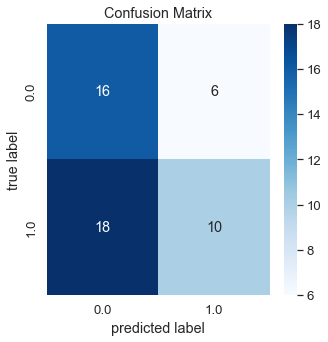

In [459]:
# Check confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Display confusion matrix
y_pred_test = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)

def plot_matrix(cm, classes, title):
    ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=True)
    ax.set(title=title, xlabel="predicted label", ylabel="true label")

plt.figure(figsize = (5,5))
plot_matrix(cm, classes = model.classes_, title = 'Confusion Matrix')